# 1) Import Libraries & Loading Dataset

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')

In [3]:
DataFrame = pd.read_csv('./Datasets/car_data.csv')

shape = DataFrame.shape
print('The Shape Of Dataset: ', shape)
print('{} Elements With {} Features'.format(shape[0], shape[1]))

The Shape Of Dataset:  (1000, 5)
1000 Elements With 5 Features


# 2) Understanding The Data

In [4]:
#Print The first 5 Elements
DataFrame.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [5]:
#Information About Data
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [6]:
#Get Statistics of Data
DataFrame.describe()

,User ID,Age,AnnualSalary,Purchased
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,40.106000,72689.000000,0.402000
std,288.819436,10.707073,34488.341867,0.490547
min,1.000000,18.000000,15000.000000,0.000000
25%,250.750000,32.000000,46375.000000,0.000000
50%,500.500000,40.000000,72000.000000,0.000000
75%,750.250000,48.000000,90000.000000,1.000000
max,1000.000000,63.000000,152500.000000,1.000000


In [7]:
#Check if there NULL values 
DataFrame.isnull().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [8]:
#Check if there duplicated values
DataFrame.duplicated().sum()

0

# 3) Exploratory Data

In [9]:
#User ID column is not important feature 
#Drop it
DataFrame.drop(['User ID'], axis=1, inplace=True)

In [10]:
#New Dataset
DataFrame.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


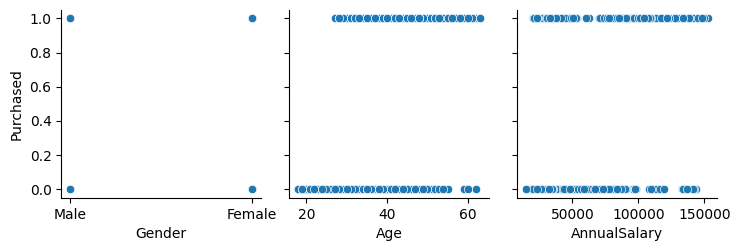

In [11]:
for i in range(0, len(DataFrame.columns), 4):
    sns.pairplot(data=DataFrame,
                x_vars=DataFrame.columns[i:i+3],
                y_vars=['Purchased'])

<AxesSubplot:ylabel='AnnualSalary'>

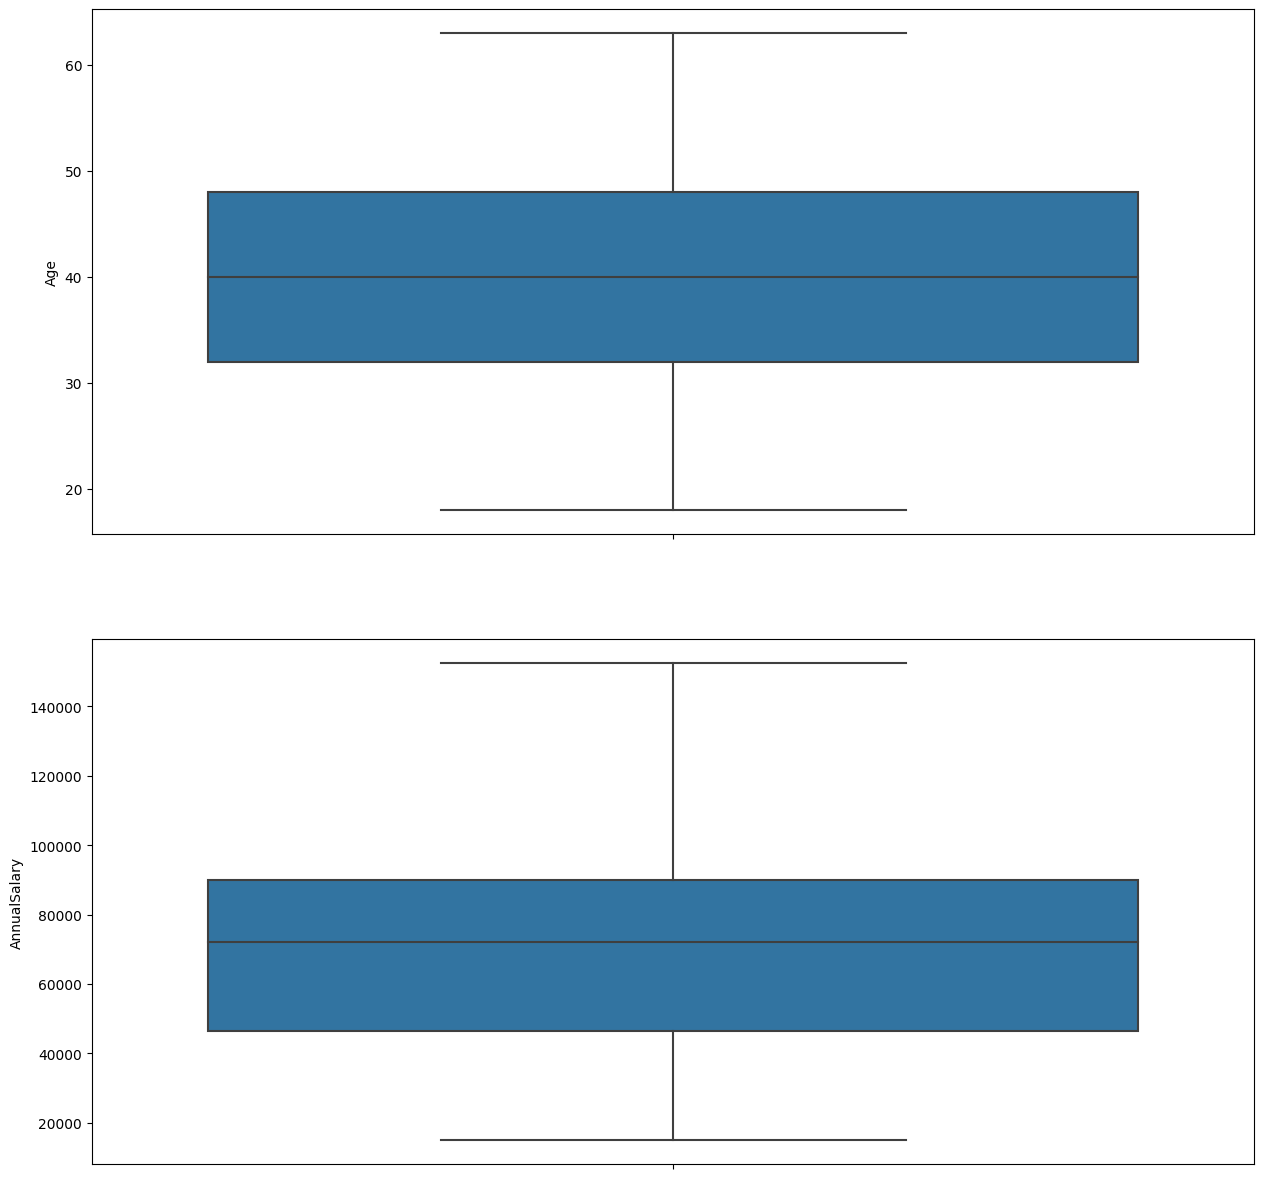

In [12]:
#Chech if there Outliers
fig,ax=plt.subplots(2,1,figsize=(15,15))
sns.boxplot(y=DataFrame['Age'],ax=ax[0])
sns.boxplot(y=DataFrame['AnnualSalary'],ax=ax[1])

<AxesSubplot:>

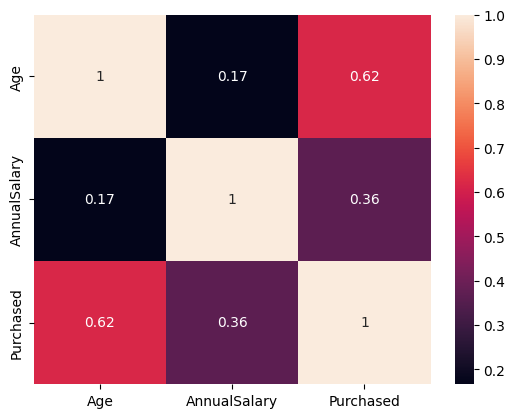

In [13]:
#Show Heatmap to get Correlation 
sns.heatmap(DataFrame.corr(), annot=True)

#### Observation:
Positive Correlation is seen between Age and Purchased as Observed from graph

# 4) Data Preprocessing

In [14]:
#We Have Dummy Values (Gender Column) 
#Convert it to One-Hot Vector

#Get Values of Gender Series (Column)
Gender = DataFrame['Gender'].values
#Then Reshape to (-1,1) or (1000,1) ==> The Same shape
Gender = Gender.reshape(-1,1)

In [15]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(drop='first',sparse=False)
OH_Gender = pd.DataFrame(OH_encoder.fit_transform(Gender))
OH_Gender #Male ==> 1, Female ==> 0.

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,1.0
996,0.0
997,0.0
998,0.0


In [16]:
#Create New Dataset After All modifications
# Gender Age AnnualSalary Purchased
Gender = OH_Gender.values.reshape(1000, )
Age = DataFrame['Age'].values
AnnualSalary = DataFrame['AnnualSalary'].values
Purchased = DataFrame['Purchased'].values


d = {'Gender': Gender,
     'Age': Age,
     'AnnualSalary': AnnualSalary,
     'Purchased': Purchased}

In [17]:
DATA = pd.DataFrame(data=d)
DATA.head()

,Gender,Age,AnnualSalary,Purchased
0,1.0,35,20000,0
1,1.0,40,43500,0
2,1.0,49,74000,0
3,1.0,40,107500,1
4,1.0,25,79000,0


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    DATA.drop(['Purchased'],axis=1),
    DATA['Purchased'],
    random_state=42,
    stratify=DATA['Purchased'],
    shuffle=True)

# 5) Create Model

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       150
           1       0.89      0.90      0.90       100

    accuracy                           0.92       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.92      0.92      0.92       250


Best Parameter: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}



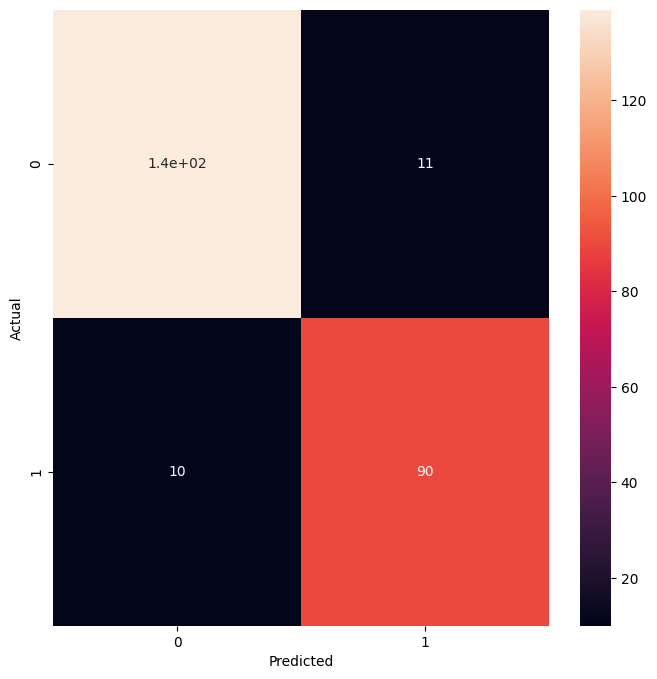

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV #To search best parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

param_grid = {
    'n_estimators': [50, 75,100, 150, 200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,16],
    'criterion' :['gini', 'entropy']
}

rcv=RandomizedSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=5)
rcv.fit(X_train,y_train)
y_pred_rcv=rcv.predict(X_test)
confusion_rcv=confusion_matrix(y_test,rcv.predict(X_test))
plt.figure(figsize=(8,8))
sns.heatmap(confusion_rcv,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
print(classification_report(y_test,y_pred_rcv))
print(f'\nBest Parameter: {rcv.best_params_}\n')